<a href="https://colab.research.google.com/github/kimjc95/computational-chemistry/blob/main/Docking_in_Colab(KOR).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Molecular Docking을 Colab에서
2023-12-19 by Joo-Chan Kim at MSBL, KAIST

리간드를 단백질에 도킹해주는 Colab Notebook입니다.

배포, 수정, 상업적 이용은 저작자 표기 조건 하에서 자유입니다. (BSD-3)

인용시에는 DOI:[10.5281/zenodo.1043061](https://zenodo.org/doi/10.5281/zenodo.10430612) 를 사용해주세요.

사용시 문제가 있으면 제 [깃헙 issue](https://github.com/kimjc95/computational-chemistry/issues)나 이메일 (kimjoochan@kaist.ac.kr)로 알려주세요.

-------------------------------

**준비물 :**

1. 리간드의 MOL 파일 (결합차수, 전하가 제대로 입력되어 있어야 함) 혹은 SMILES 문자열

2. 단백질의 PDB 파일 (heterogen이 있거나 일부 원자가 빠져있어도 상관 X) 혹은 4자리 PDB ID

3. Google 계정, 인터넷 연결

In [ ]:
#@title Conda 설치
#@markdown 런타임이 종료되었다가 다시 연결되는데, 당황하지 마시고 이어서 실행하시면 됩니다.

# Colab에서 Conda 실행하기 위해 준비
!pip install -q condacolab
import condacolab
condacolab.install()
# CUDA 12.2부터 cudatoolkit이 cuda-toolkit으로 바뀌면서 에러 발생
!rm -rf /usr/local/conda-meta/pinned

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.1.0-1/Mambaforge-23.1.0-1-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:10
🔁 Restarting kernel...


In [ ]:
#@title Dependencies 설치
#@markdown (1분 가량 소요)
#@markdown 이 틈에 Receptor PDB 파일과 Ligand MOL 파일을 (있으면) 업로드 해주세요.

import subprocess

subprocess.run("git clone -q --depth=1 https://github.com/QVina/qvina.git", shell=True)
subprocess.run("chmod -R 755 /content/qvina", shell=True)
subprocess.run("mamba install -q -c conda-forge numpy scipy rdkit prolif parmed biopython pdbfixer openmmforcefields nglview mdanalysis", shell=True)
subprocess.run("pip3 install -q meeko pdb4amber", shell=True)

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdFMCS
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Lipinski import RotatableBondSmarts
from openff.toolkit import Molecule
from openmmforcefields.generators import GAFFTemplateGenerator
from IPython.display import Image
from pdbfixer import PDBFixer
from openmm import *
from openmm.app import *
from openmm.unit import *
from Bio.PDB import *
import os
import random
import locale
import warnings
import parmed
import numpy as np
import nglview as nv
import MDAnalysis as mda
import prolif as plf
from MDAnalysis.analysis import distances
from google.colab import output
output.enable_custom_widget_manager()
print("설치 완료!")

Dependencies intallation complete!


In [ ]:
# @markdown (선택사항) 파일 저장을 위해 Google Drive에 연결합니다. 권한을 수락해주세요.
from google.colab import drive

drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


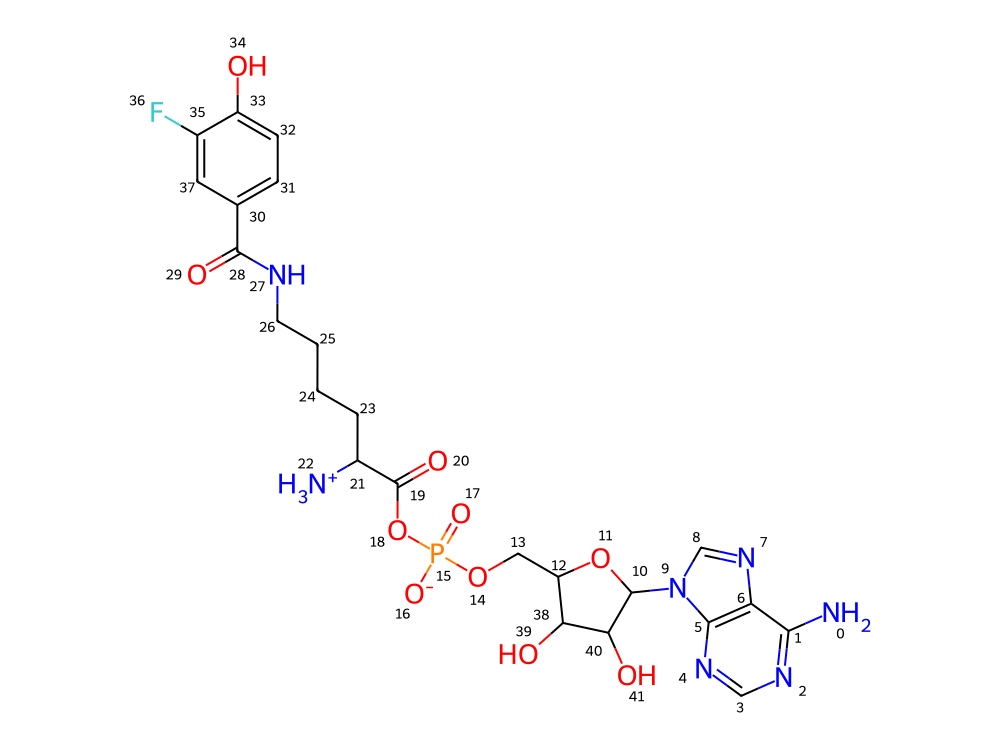

In [ ]:
#@title **1. Ligand.pdbqt 준비**
#@markdown 수소가 없는 ligand MOL 파일의 이름을 입력하시거나, 리간드의 SMILES를 입력해주세요.

#@markdown 둘다 입력하시면 파일만 읽어들입니다.

#@markdown 구조를 확인하고 전하나 결합차수가 맞는지 확인해주세요.

#@markdown 그림에 나온 원자번호는 0부터 셉니다.

ligandFile = "" #@param {type:"string"}
ligandSMILES = "Nc:1:n:[cH]:n:c:2:c:1:n:[cH]:n:2C3OC(CO[P]([O-])(=O)OC(=O)C([NH3+])CCCCNC(=O)c:4:[cH]:[cH]:c(O):c(F):[cH]:4)C(O)C3O" #@param {type:"string"}

IPythonConsole.molSize = 1000,750
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.drawOptions.addBondIndices = False

if ligandFile != "":
    try:
        mol = Chem.MolFromMolFile(ligandFile)
    except:
        print("MOL파일을 읽을 수 없습니다.")
elif ligandSMILES != "":
    mol = Chem.MolFromSmiles(ligandSMILES)

else:
    print("리간드 정보가 없습니다: MOL파일 혹은 SMILES를 입력하세요.")

Chem.SanitizeMol(mol)
Chem.rdCoordGen.AddCoords(mol)
mol

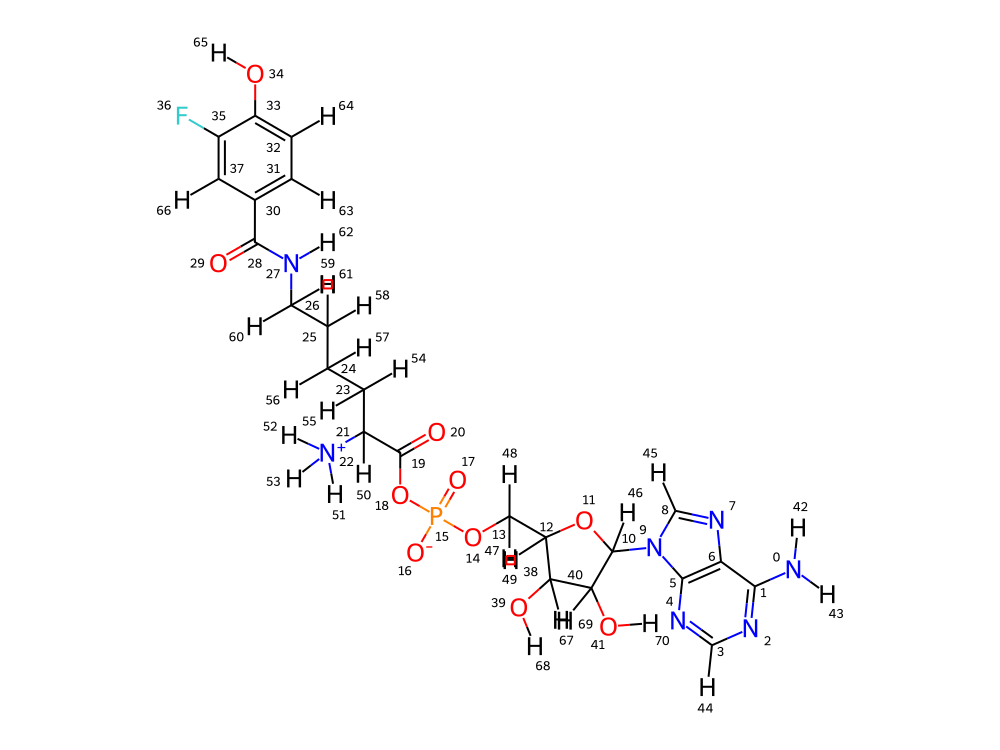

In [ ]:
# @markdown 수소를 자동으로 더합니다.
mol_wH = Chem.rdmolops.AddHs(mol, explicitOnly=False, addCoords=True)
mol_wH

Number of rotatable bonds : 17
Number of amide bonds : 1


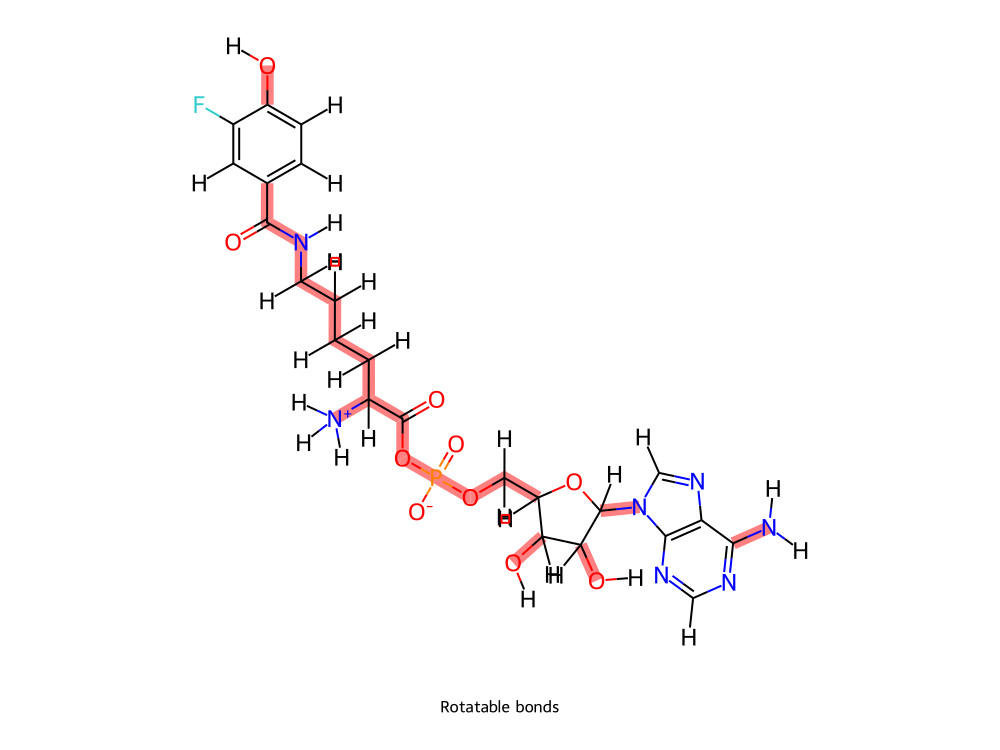

In [ ]:
#@markdown 회전 가능한 공유결합을 붉은색으로 표시해줍니다.

d = Chem.Draw.rdMolDraw2D.MolDraw2DCairo(1000, 750)

n_rot_bonds = Chem.rdMolDescriptors.CalcNumRotatableBonds(mol_wH)
n_amide_bonds = Chem.rdMolDescriptors.CalcNumAmideBonds(mol_wH)
print("회전 가능한 공유 결합 갯수 : "+str(n_rot_bonds))
print("아마이드 결합 갯수 : "+str(n_amide_bonds))

rot_atom_pairs = mol_wH.GetSubstructMatches(RotatableBondSmarts)
rot_bonds = list(set([mol_wH.GetBondBetweenAtoms(*ap).GetIdx() for ap in rot_atom_pairs]))

Chem.Draw.rdMolDraw2D.PrepareAndDrawMolecule(d, mol_wH, legend='Rotatable bonds', highlightBonds=rot_bonds)
d.WriteDrawingText("rotatable_bond_highlight.png")
Image("rotatable_bond_highlight.png")

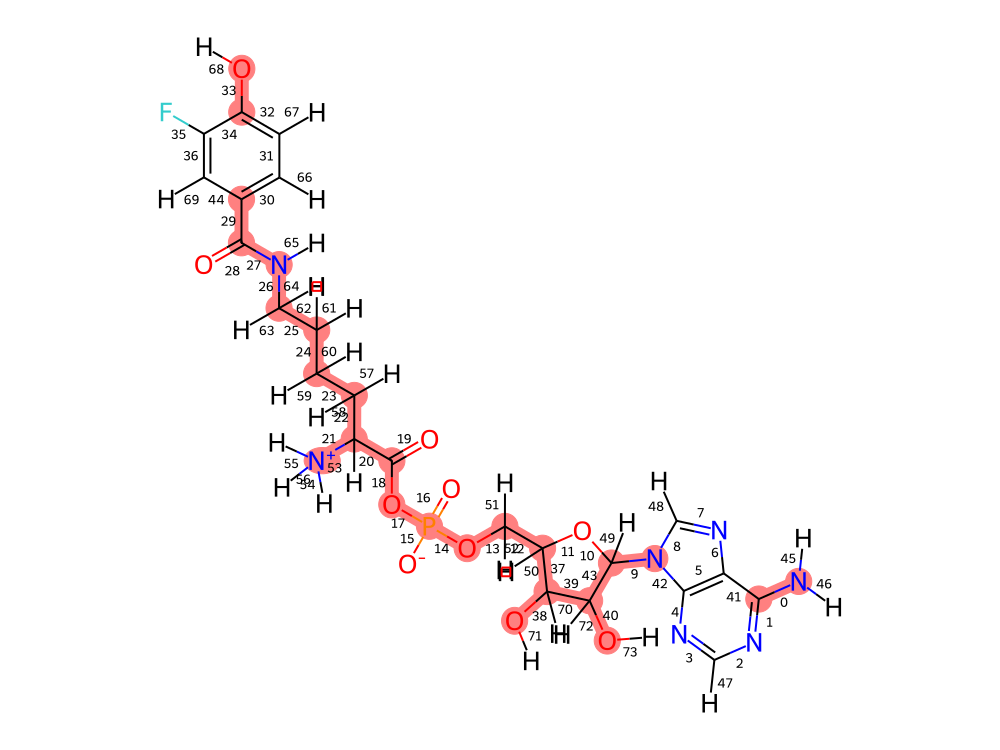

In [ ]:
# @markdown 이제 원자가 아닌 결합에 번호를 붙여 표시해드립니다.

# @markdown 잘 보고 회전을 고정하고 싶은 결합 번호를 0 1 2 이런 식으로 입력해주세요.
IPythonConsole.drawOptions.addAtomIndices = False
IPythonConsole.drawOptions.addBondIndices = True

fix_bonds = "0 27 29" #@param {type:"string"}
fix_bonds_idx = [int(s) for s in fix_bonds.split(' ')]
mol_wH

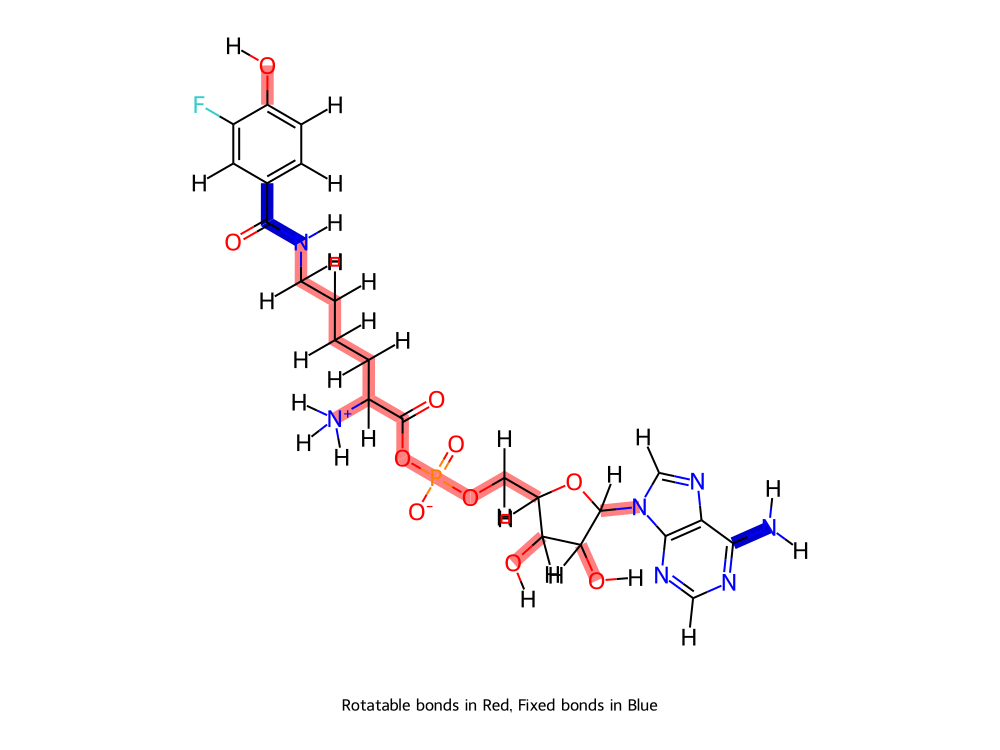

In [ ]:
# @markdown 고정된 결합은 파랑색으로 표시하였습니다.

# @markdown 수정이 필요하시면 다시 위의 셀을 실행해주세요.

bond_colors = {}

for bond in Chem.rdchem.Mol.GetBonds(mol_wH):
    if bond.GetIdx() in fix_bonds_idx:
        bond_colors[bond.GetIdx()] = (0.0,0.0,0.8)
    elif bond in rot_bonds:
        bond_colors[bond.GetIdx()] = (0.8,0.0,0.0)

d2 = Chem.Draw.rdMolDraw2D.MolDraw2DCairo(1000, 750)

Chem.Draw.rdMolDraw2D.PrepareAndDrawMolecule(d2, mol_wH, legend='Rotatable bonds in Red, Fixed bonds in Blue',
                                            highlightBonds=rot_bonds, highlightBondColors=bond_colors)

d2.WriteDrawingText("fixed_bond_highlight.png")
Image("fixed_bond_highlight.png")

In [ ]:
# @markdown 리간드 3차원 구조를 최적화할 ForceField를 선택해주세요.

# @markdown UFF (Universal ForceField)는 대부분의 원소에 적용 가능합니다.

# @markdown MMFF (Merck Molecular ForceField 94)는 유기분자에 적합합니다.

FFtype = "UFF" #@param ['MMFF','UFF']

# @markdown 최적화된 구조는 ligand.sdf에 저장됩니다.

Chem.AllChem.EmbedMolecule(mol_wH)

if FFtype == 'UFF':
    Chem.AllChem.UFFOptimizeMolecule(mol_wH, maxIters=200)
else:
    Chem.AllChem.MMFFOptimizeMolecule(mol_wH, maxIters=200)

writer = Chem.SDWriter('ligand.sdf')
writer.write(mol_wH)

view = nv.NGLWidget()
view.add_structure(nv.RdkitStructure(mol_wH))
view._set_size('1000px','750px')
view

NGLWidget()

In [ ]:
# @markdown prepare_ligand.py로 ligand.pdbqt 파일을 준비합니다.

# 원래 SMARTS로 입력해야 하지만 귀찮으므로 SMILES로 fixed bond 지정
SMILES = Chem.rdmolfiles.MolToSmiles(mol_wH)
rotatable = ""

for i in fix_bonds_idx:
    bond = mol_wH.GetBondWithIdx(i)
    a1 = bond.GetBeginAtom().GetIdx()+1 # RDKit은 0부터 셈
    a2 = bond.GetEndAtom().GetIdx()+1
    rotatable = rotatable + ' -r "'+SMILES+'" -b '+str(a1)+" "+str(a2)

if os.system('mk_prepare_ligand.py -i ligand.sdf -o ligand.pdbqt'+rotatable) == 0:
    print("ligand PDBQT 파일을 생성하였습니다.")

ligand.pdbqt successfully generated!


In [ ]:
# @title **2. Receptor.pdbqt 준비**
# @markdown Receptor PDB 파일명 또는 PDB ID를 입력해주세요.

# @markdown 둘다 입력하시면 파일을 우선적으로 읽어들입니다.

warnings.filterwarnings("ignore")

receptorFile = "" # @param {type:"string"}
receptorID = "8DQI" # @param {type: "string"}


if receptorFile != "":
    try:
        parser = PDBParser()
        structure = parser.get_structure("receptor", receptorFile)
    except:
        print("PDB 파일을 읽을 수 없습니다.")
    fileFalg = True
elif receptorID != "":
    try:
        pdblist = PDBList()
        pdbfile = pdblist.retrieve_pdb_file(receptorID, pdir="/content/")
        parser = MMCIFParser()
        structure = parser.get_structure("receptor", pdbfile)
    except:
        print("PDB ID로 구조를 불러올 수 없습니다.")
    fileFlag = False
else:
    print("PDB 정보를 입력해주세요.")

view2 = nv.NGLWidget()
view2._set_size('1000px','750px')
view2.add_structure(nv.BiopythonStructure(structure))
view2

NGLWidget()

In [ ]:
# @markdown 위 위젯에선 각 chain별로 다른 색으로 표시됩니다.

# @markdown 유지하고 싶은 chain을 골라주세요.

chains_to_keep = 'A' # @param {type:"string"}

# @markdown 수소를 더해줄 기준 pH를 설정하세요.
pH = 7.4 #@param {type:"slider", min:0.0, max:14.0, step:0.1}
# @markdown 고쳐진 PDB 파일은 receptor-final.pdb로 저장됩니다.

# @markdown 금속 이온을 보존하고 싶다면 아래 체크박스를 해제하세요. 대신에 금속 외 다른 heterogen이 없어야 합니다.
remove_Heterogens = True # @param {type:"boolean"}

if fileFlag:
    fixer = PDBFixer(filename=receptorFile)
else:
    fixer = PDBFixer(pdbid=receptorID)

# PDBFixer로 수선하기
chains_to_delete = []

for chain in fixer.topology.chains():
    if chain.id not in chains_to_keep:
        chains_to_delete.append(chain.index)

fixer.removeChains(chains_to_delete)
fixer.findMissingResidues()
fixer.findNonstandardResidues()
fixer.replaceNonstandardResidues()
if remove_Heterogens:
    fixer.removeHeterogens(False)
fixer.findMissingAtoms()
fixer.addMissingAtoms()
fixer.addMissingHydrogens(pH)

# Amber14 forcefield로 steric clash 없애주기
forcefield = ForceField("amber14-all.xml", "amber14/tip3pfb.xml")
system = forcefield.createSystem(fixer.topology, CutoffNonPeriodic, 1.0*nanometers, HBonds, None, True)
integrator = LangevinMiddleIntegrator(300,1,1)
simulation = Simulation(fixer.topology, system, integrator)
simulation.context.setPositions(fixer.positions)
simulation.minimizeEnergy()

with open('receptor-fixed.pdb', 'w') as f:
    positions = simulation.context.getState(getPositions=True).getPositions()
    PDBFile.writeFile(fixer.topology, positions, f)

# PDB4Amber로 amber format에 맞게 residue이름 고쳐주기
os.system('pdb4amber -i receptor-fixed.pdb -o receptorwithH.pdb -p --most-populous')

warnings.filterwarnings(action='ignore')

# 왜인진 모르겠지만 N-terminus amine hydrogen 이름이 잘못 붙여짐.
parser = PDBParser()
s = parser.get_structure('receptor', 'receptorwithH.pdb')

for chain in s.get_chains():
    for atom in list(chain.get_residues())[0].get_atoms():
        if atom.get_name() == 'H':
            setattr(atom, "id", 'H1')
            setattr(atom, "name", 'H1')
            setattr(atom, "fullname", ' H1  ')
            print(atom.id)

# 위치를 원점으로 보정하기
com = s.center_of_mass()
s.transform(np.array([[1,0,0],[0,1,0],[0,0,1]]), tran=-1*com)

# 최종 PDB 파일 저장하기
io = PDBIO()
io.set_structure(s)
io.save("receptor-final.pdb")

view3 = nv.NGLWidget()
view3._set_size('1000px','750px')
view3.add_structure(nv.FileStructure("receptor-final.pdb"))
view3.add_surface(lowResolution= True, smooth=1,opacity=0.4)

view3

H1


NGLWidget()

In [ ]:
# @markdown 위 위젯에서 원자를 클릭하시고 아래 좌표 입력칸을 비워두세요.

# @markdown 원자가 선택되면 위젯 왼쪽 위 구석에 희미하게 원자 정보가 표시됩니다.

# @markdown 혹은 아래 체크 박스를 선택하고 Grid Box center 좌표 (옹스트롬 단위)를 입력하세요.

set_center_manually = True #@param {type:"boolean"}

center_x = "10" #@param {type:"string"}
center_y = "5" #@param {type:"string"}
center_z = "-10" #@param {type:"string"}

if not set_center_manually:
    if view3.picked == {}:
        print("박스의 중심 원자가 선택되지 않았습니다.")
    else:
        center_x = view3.picked["atom1"]["x"]
        center_y = view3.picked["atom1"]["y"]
        center_z = view3.picked["atom1"]["z"]
else:
    try:
        center_x = float(center_x)
        center_y = float(center_y)
        center_z = float(center_z)
    except:
        print("박스 중심이 제대로 입력되지 않았습니다.")

print(f"박스 중심 좌표는 x:{center_x:.3f}A, y:{center_y:.3f}A, z:{center_z:.3f}A입니다.")


Box Center is 10.000, 5.000, -10.000


In [ ]:
# @markdown Grid Box의 길이, 폭, 높이를 입력하세요.
len_x = "35" #@param {type:"string"}
len_y = "50" #@param {type:"string"}
len_z = "40" #@param {type:"string"}

# @markdown 이 셀을 실행 후 아래 위젯에서 박스 크기와 위치를 확인하세요.

# @markdown center 좌표나 box 크기를 바꾼 후 이 셀을 다시 실행해 확인하세요.

# @markdown 빨강이 x축, 초록이 y축, 파랑이 z축입니다.
show_sidechain = False # @param {type:"boolean"}

try:
    len_x = float(len_x)
    len_y = float(len_y)
    len_z = float(len_z)
except:
    print("박스 크기가 제대로 입력되지 않았습니다.")

flexFlag = False

# Box 꼭지점 좌표 설정
corner1 = [center_x+len_x/2, center_y+len_y/2, center_z+len_z/2]
corner2 = [center_x-len_x/2, center_y+len_y/2, center_z+len_z/2]
corner3 = [center_x-len_x/2, center_y-len_y/2, center_z+len_z/2]
corner4 = [center_x+len_x/2, center_y-len_y/2, center_z+len_z/2]
corner5 = [center_x+len_x/2, center_y+len_y/2, center_z-len_z/2]
corner6 = [center_x-len_x/2, center_y+len_y/2, center_z-len_z/2]
corner7 = [center_x-len_x/2, center_y-len_y/2, center_z-len_z/2]
corner8 = [center_x+len_x/2, center_y-len_y/2, center_z-len_z/2]

view3 = nv.NGLWidget()
view3._set_size('1000px','750px')
view3.add_structure(nv.FileStructure("receptor-final.pdb"))
view3.add_surface(lowResolution= True, smooth=1,opacity=0.4)

# Box 그리기
view3.shape.add_cylinder(corner1, corner2, [1,1,1], [0.1])
view3.shape.add_cylinder(corner2, corner3, [1,1,1], [0.1])
view3.shape.add_cylinder(corner3, corner4, [1,1,1], [0.1])
view3.shape.add_cylinder(corner4, corner1, [1,1,1], [0.1])
view3.shape.add_cylinder(corner1, corner5, [1,1,1], [0.1])
view3.shape.add_cylinder(corner2, corner6, [1,1,1], [0.1])
view3.shape.add_cylinder(corner3, corner7, [0,0,1], [0.2])
view3.shape.add_cylinder(corner4, corner8, [1,1,1], [0.1])
view3.shape.add_cylinder(corner5, corner6, [1,1,1], [0.1])
view3.shape.add_cylinder(corner6, corner7, [0,1,0], [0.2])
view3.shape.add_cylinder(corner7, corner8, [1,0,0], [0.2])
view3.shape.add_cylinder(corner8, corner5, [1,1,1], [0.1])

if show_sidechain:
    view3.add_licorice("sidechain")
view3

NGLWidget()

In [ ]:
# @markdown 지정하고 싶은 Flexible residue들을 쉼표로 구분하여 입력하세요.

# @markdown "Chain ID:Residue name:Residue number" 식으로 공백없이 써주세요.

# @markdown Residue 여러개는 공백없이 쉼표로 구분해주세요.

# @markdown 없다면 이 셀을 실행 안하셔도 됩니다.

flexible_residues = "A:SER:156,A:TYR:229" # @param {type:"string"}

# @markdown 지정된 flexible residue를 확인하세요.

fr = flexible_residues.split(',')

flex_res = ""
selection = ""

if fr != [""]:
    flexFlag = True

if flexFlag:
    try:
        for i, res in enumerate(fr):
            flex_res = flex_res + " -f "+res
            resinfo = res.split(':')
            selection = selection + "(:"+resinfo[0]+" and "+resinfo[2]+")"
            if i != (len(fr)-1):
                selection = selection + " or "
    except:
        print("Flexible residue 정보가 제대로 입력되지 않았습니다.")

# 박스 다시 그리기
view3 = nv.NGLWidget()
view3._set_size('1000px','750px')
view3.add_structure(nv.FileStructure("receptor-final.pdb"))
view3.add_surface(lowResolution= True, smooth=1,opacity=0.4)
view3.shape.add_cylinder(corner1, corner2, [1,1,1], [0.1])
view3.shape.add_cylinder(corner2, corner3, [1,1,1], [0.1])
view3.shape.add_cylinder(corner3, corner4, [1,1,1], [0.1])
view3.shape.add_cylinder(corner4, corner1, [1,1,1], [0.1])
view3.shape.add_cylinder(corner1, corner5, [1,1,1], [0.1])
view3.shape.add_cylinder(corner2, corner6, [1,1,1], [0.1])
view3.shape.add_cylinder(corner3, corner7, [0,0,1], [0.2])
view3.shape.add_cylinder(corner4, corner8, [1,1,1], [0.1])
view3.shape.add_cylinder(corner5, corner6, [1,1,1], [0.1])
view3.shape.add_cylinder(corner6, corner7, [0,1,0], [0.2])
view3.shape.add_cylinder(corner7, corner8, [1,0,0], [0.2])
view3.shape.add_cylinder(corner8, corner5, [1,1,1], [0.1])

# Flexible residue 강조해주기
if flexFlag:
    view3.add_licorice(selection=selection, color='red')
    view3.add_surface(selection=selection, color='red',
                      lowresolution=False, smooth=1,opacity=0.8)

view3

NGLWidget()

In [ ]:
# @markdown prepare_receptor.py로 receptor.pdbqt를 준비합니다.

if os.system('mk_prepare_receptor.py --pdb receptor-final.pdb -o receptor.pdbqt --box_size '+str(len_x)+' '+str(len_y)+' '+str(len_z)+' --box_center '+str(center_x)+' '+str(center_y)+' '+str(center_z)+flex_res) == 0:
    print('receptor PDBQT 파일을 생성하였습니다.')

receptor.pdbqt successfully generated.


In [ ]:
# @title **3. QuickVina2를 이용한 도킹**
output = "ligand_out.pdbqt"
# @markdown Exhaustiveness 값 (얼마나 자세히 탐색할지)을 설정하세요. 클 수록 오래 걸립니다.
exhaustiveness = 512 #@param {type:"slider", min:8, max:512, step:8}
# @markdown 아래 출력되는 도킹 로그는 docking_log.txt에도 저장됩니다.

# Flexible residue 지정하면 receptor.pdbqt 파일이 2개로 쪼개짐
if flexFlag:
    rigid = "receptor = receptor_rigid.pdbqt\n"
    flex_rec = "flex = receptor_flex.pdbqt\n"
else:
    rigid = "receptor.pdbqt\n"
    flex_rec = ""

# config 파일에 매개변수 저장
with open('config', 'w') as f:
    f.write(rigid)
    f.write("ligand = ligand.pdbqt\n")
    f.write("center_x = "+str(center_x)+'\n')
    f.write("center_y = "+str(center_x)+'\n')
    f.write("center_z = "+str(center_x)+'\n')
    f.write("size_x = "+str(len_x)+'\n')
    f.write("size_y = "+str(len_y)+'\n')
    f.write("size_z = "+str(len_z)+'\n')
    f.write("out = "+output+'\n')
    f.write("log = docking_log.txt\n")
    f.write("exhaustiveness = "+str(exhaustiveness)+'\n')
    f.write(flex_rec)

# python 실행하다 shell 실행할 때 locale 설정이 바뀌는 경우가 있어 재설정해주기
locale.getpreferredencoding = lambda: "UTF-8"
!/content/qvina/bin/qvina2.1 --config config

############################################################################
# If you used Quick Vina 2 in your work, please cite:                      #
#                                                                          #
# Amr Alhossary, Stephanus Daniel Handoko, Yuguang Mu, and Chee-Keong Kwoh,#
# Fast, Accurate, and Reliable Molecular Docking with QuickVina 2,         #
# Bioinformatics (2015), doi: 10.1093/bioinformatics/btv082                #
#                                                                          #
# You are also encouraged to cite Quick Vina 1:                            #
# Stephanus Daniel Handoko, Xuchang Ouyang, Chinh Tran To Su, Chee Keong   #
# Kwoh, Yew Soon Ong,                                                      #
# QuickVina: Accelerating AutoDock Vina Using Gradient-Based Heuristics for#
# Global Optimization,                                                     #
# IEEE/ACM Transactions on Computational Biology and Bioinformatics,vol.9, #

In [ ]:
# @title **4. 결과 분석**
# @markdown ligand_out.pdbqt 파일을 읽어들입니다.

warnings.filterwarnings("ignore")

pdb = PDBFile('receptor-final.pdb')

# receptor.pdbqt 파일에는 nonpolar hydrogen이 없으므로 topology 맞춰주기
modeller = Modeller(pdb.topology, pdb.positions)
Hstodelete = []

for bond in modeller.topology.bonds():
    A = bond[0]
    B = bond[1]

    if A.element == element.hydrogen and B.element == element.carbon:
        Hstodelete.append(A)
    elif A.element == element.carbon and B.element == element.hydrogen:
        Hstodelete.append(B)

Hstodelete = list(set(Hstodelete))
modeller.delete(Hstodelete)

def typeConverter(universe):
    # AutoDock atom type을 MDAnalysis가 이해할 수 있게 재설정해주기
    type2element = {'H':'H','C':'C','A':'C','N':'N','P':'P','S':'S','Br':'Br','BR':'Br','I':'I','F':'F','Cl':'Cl','CL':'Cl',
                    'NA':'N','OA':'O','SA':'S','OS':'O','NS':'N','HD':'H','HS':'H','Mg':'Mg','Ca':'Ca','Fe':'Fe','Zn':'Zn',
                    'Mn': 'Mn','MG':'Mg','CA':'Ca','FE':'Fe','ZN':'Zn','MN':'Mn','G':'C','J':'C','Q':'C','GA':'C'}

    elements = []
    for i in range(len(universe.atoms)):
        elements.append(type2element[universe.atoms.types[i]])
    universe.add_TopologyAttr('types', elements)
    universe.add_TopologyAttr('elements', elements)
    return universe

# MDAnalysis가 multi-model PDBQT파일을 읽지 못해 통으로 읽고 나눠주기
ligs = typeConverter(mda.Universe("ligand_out.pdbqt"))
size = len(ligs.atoms)/9

l = []
for i in range(9):
    b_i = int(i*size)
    e_i = int((i+1)*size-1)
    l.append(ligs.select_atoms("index "+str(b_i)+':'+str(e_i), sorted=False).convert_to("PARMED"))

In [ ]:
# @markdown 보고 싶은 pose를 선택하세요.
if flexFlag:
    r = typeConverter(mda.Universe("receptor_rigid.pdbqt")).atoms.convert_to("PARMED")
else:
    r = parmed.read_PDB("receptor-final.pdb")

pose = "2" # @param [1,2,3,4,5,6,7,8,9]

# PARMED structure class는 합치기 가능
c = r+l[int(pose)-1]

view4 = nv.NGLWidget()
view4._set_size('1000px', '750px')
view4.add_structure(nv.ParmEdTrajectory(c), defaultRepresentation=False)
view4.add_cartoon(selection="protein")
view4.add_spacefill(selection="ion")
view4.add_surface(selection="protein or ion", smooth=1, opacity=0.5)
view4.add_ball_and_stick(selection="not protein and not ion", aspectRatio=2.5)
view4

NGLWidget()

In [ ]:
# @markdown 위에서 정한 docked pose를 파일로 저장합니다.
save_to_GoogleDrive = True # @param {type:"boolean"}

u = mda.Universe(c)

forcefield = ForceField("amber14-all.xml", "amber14/tip3pfb.xml")

flex_res = []

# ligand_out.pdbqt에 flexible residue들의 sidechain 위치정보도 들어있으므로 receptor에 합쳐줘야 함
if flexFlag:
    fr = flexible_residues.split(',')
    for res in fr:
        res_info = res.split(':')
        flex_res.append(u.select_atoms("protein and resname "+res_info[1]+" and resnum "+res_info[2]))

for i in range(len(flex_res)):
    res = u.atoms.split('residue')[-i-1] # flexible residue들은 맨 뒤에 추가됨
    # alpha carbon과 amide carbon 사이 거리로 flexible residue들이 원래 속한 backbone 찾아주기
    a = res.select_atoms("name CA")
    dists = []
    for res2 in flex_res:
        resids_A, resids_B, dist = distances.dist(a,res2.select_atoms("name C"))
        dists.append(list(dist)[0])
    nearest = flex_res[dists.index(min(dists))][0]
    res.residues.resnames = nearest.resname
    res.residues.resnums = nearest.resnum


def atom_indice_mapping(rdkit_mol, pdbqt_mol):
    # ligand.pdbqt와 ligand_out.pdbqt는 원자 순서가 같으므로 mapping 가능
    map = {}
    for idx_A, coord_A in enumerate(pdbqt_mol.GetConformer().GetPositions()):
        dr = []
        for idx_B, coord_B in enumerate(rdkit_mol.GetConformer().GetPositions()):
            dx = abs(coord_A[0] - coord_B[0])
            dy = abs(coord_A[1] - coord_B[1])
            dz = abs(coord_A[2] - coord_B[2])
            dr.append(dx+dy+dz)
        map[idx_A] = dr.index(min(dr))
    return map

def set_conformer_and_add_H(mol_A, mol_B, map):
    # 선택된 ligand의 pose대로 수소를 더해줌

    mol_C = Chem.Mol(mol_A) # 혹시 모르니 분자 복사
    mol_C.RemoveAllConformers() # 좌표 정보 삭제
    conf_A = Chem.Conformer(mol_A.GetNumAtoms())
    conf_B = mol_B.GetConformer()

    xs = []
    ys = []
    zs = []
    for idx, coord in enumerate(conf_B.GetPositions()):
        conf_A.SetAtomPosition(map[idx], coord)
        xs.append(coord[0])
        ys.append(coord[1])
        zs.append(coord[2])

    mol_C.AddConformer(conf_A) # PDBQT에 나온 좌표로 업데이트

    size_x = max(xs) - min(xs)
    size_y = max(ys) - min(ys)
    size_z = max(zs) - min(zs)
    fixed_atom_indices = map.values()

    # nonpolar H들의 위치를 랜덤으로 생성
    for idx in range(mol_C.GetNumAtoms()):
        if idx not in fixed_atom_indices:
            x = random.random()*size_x + min(xs)
            y = random.random()*size_y + min(ys)
            z = random.random()*size_z + min(zs)
            mol_C.GetConformer().SetAtomPosition(idx, (x,y,z))

    # nonpolar H들만 위치를 최적화
    for i in range(1000):
        if FFtype == 'UFF':
            if Chem.AllChem.UFFOptimizeMolecule(mol_C, maxIters=3, ignoreInterfragInteractions=False) == 0:
                break
        else:
            if Chem.AllChem.MMFFOptimizeMolecule(mol_C, maxIters=3, ignoreInterfragInteractions=False) == 0:
                break
        for j in fixed_atom_indices:
            mol_C.GetConformer().SetAtomPosition(j, list(conf_A.GetPositions())[j])

    Chem.rdmolops.AssignStereochemistryFrom3D(mol_C)

    return mol_C

pdbqt_mol = typeConverter(mda.Universe("ligand.pdbqt")).atoms
pdbqt_mol.guess_bonds()
lig_wo_pose = pdbqt_mol.convert_to("RDKIT")

lig_w_pose = u.select_atoms("not protein and not (element Mg Ca Fe Zn Mn)").convert_to("RDKIT")
map = atom_indice_mapping(mol_wH, lig_wo_pose)
lmol = set_conformer_and_add_H(mol_wH, lig_w_pose, map)
prot = u.select_atoms("protein or (element Mg Ca Fe Zn Mn)").convert_to("PARMED")

# PDBQT로부터 PDB 복원하기
modeller2 = Modeller(modeller.topology, prot.positions)
modeller2.addHydrogens(forcefield, pH)

# GAFF-2.11로 ligand parameterization
molecule = Molecule.from_rdkit(lmol, hydrogens_are_explicit=True)
molecule.generate_unique_atom_names()
molecule.assign_partial_charges("mmff94")
gaff = GAFFTemplateGenerator(molecules=molecule)
forcefield.registerTemplateGenerator(gaff.generator)

ligtop = molecule.to_topology().to_openmm()

modeller2.add(ligtop, mda.Universe(lmol).atoms.convert_to("PARMED").positions)

# ligand-protein complex 구조 최적화
system = forcefield.createSystem(modeller2.topology, CutoffNonPeriodic, 1.0*nanometers, None, True, True)
integrator = LangevinMiddleIntegrator(300,1,1)
simulation = Simulation(modeller2.topology, system, integrator)
simulation.context.setPositions(modeller2.positions)
simulation.minimizeEnergy()
positions = simulation.context.getState(getPositions=True).getPositions()
complex_parmed = parmed.openmm.load_topology(modeller2.topology, system, positions)
u = mda.Universe(complex_parmed)


# 파일 쓰기
filename = "docked_pose_"+str(pose)+".pdb"
pdb = mda.coordinates.PDB.PDBWriter(filename=filename, bonds="all", n_atoms=u.atoms.n_atoms)
pdb.write_all_timesteps(u)

if save_to_GoogleDrive:
    os.system("cp "+filename+" /content/drive/MyDrive/")

In [ ]:
# @markdown 해당 pose에서의 리간드와 단백질의 상호작용을 도표로 나타내줍니다.

# @markdown 클릭, 드래그 등으로 수정할 수 있습니다.

prot = u.select_atoms("protein or (element Mg Ca Fe Zn Mn)")
lig = u.select_atoms("not protein and not (element Mg Ca Fe Zn Mn)")

fp = plf.Fingerprint()
fp.run(u.trajectory, lig, prot)
fp.plot_lignetwork(plf.Molecule.from_rdkit(lmol))

  0%|          | 0/1 [00:00<?, ?it/s]

사용된 도구들의 출처는 다음과 같습니다.

*  RDKit
> RDKit: Open-source cheminformatics. https://www.rdkit.org

*  OpenMM
> P. Eastman, J. Swails, J. D. Chodera, R. T. McGibbon, Y. Zhao, K. A. Beauchamp, L.-P. Wang, A. C. Simmonett, M. P. Harrigan, C. D. Stern, R. P. Wiewiora, B. R. Brooks, and V. S. Pande. (2017)“OpenMM 7: Rapid development of high performance algorithms for molecular dynamics.” PLOS Comp. Biol. 13(7): e1005659. DOI:[10.1371/journal.pcbi.1005659](https://doi.org/10.1371/journal.pcbi.1005659)

*  OpenFF Toolkit
> David L. Mobley, Caitlin C. Bannan, Andrea Rizzi, Christopher I. Bayly, John D. Chodera, Victoria T. Lim, Nathan M. Lim, Kyle A. Beauchamp, David R. Slochower, Michael R. Shirts, Michael K. Gilson, and Peter K. Eastman. (2018) "Escaping Atom Types in Force Fields Using Direct Chemical Perception." J. Chem. Theory Comput. 14(11): 6076–6092. DOI:[10.1021/acs.jctc.8b00640](https://doi.org/10.1021/acs.jctc.8b00640)

*   AutoDock Suite
> Forli, S., Huey, R., Pique, M. E., Sanner, M. F., Goodsell, D. S., & Olson, A. J. (2016) "Computational protein–ligand docking and virtual drug screening with the AutoDock suite" Nature protocols, 11(5), 905-919. DOI:[10.1038/nprot.2016.051](https://doi.org/10.1038/nprot.2016.051)

*   QuickVina2
> Amr Alhossary, Stephanus Daniel Handoko, Yuguang Mu, and Chee-Keong Kwoh. (2015) "Fast, Accurate, and Reliable Molecular Docking with QuickVina 2" Bioinformatics 31(13): 2214-2216. DOI:[10.1093/bioinformatics/btv082](https://doi.org/10.1093/bioinformatics/btv082)

*  NGLViewer
> Hai Nguyen, David A Case, Alexander S Rose. (2018) "NGLview - Interactive molecular graphics for Jupyter notebooks" Bioinformatics 34(7): 1241-1242. DOI:[10.1093/bioinformatics/btx789](https://doi.org/10.1093/bioinformatics/btx789)

* MDAnalysis
> N. Michaud-Agrawal, E. J. Denning, T. B. Woolf, and O. Beckstein. (2011) "MDAnalysis: A Toolkit for the Analysis of Molecular Dynamics Simulations." J. Comput. Chem. 32(10): 2319-2327, DOI:[10.1002/jcc.21787](https://doi.org/10.1002/jcc.21787)

* BioPython.PDB
> Thomas Hamelryck, Bernard Manderick. (2003) "PDB file parser and structure class implemented in Python." Bioinformatics, 19(17): 2308–2310. DOI:[10.1093/bioinformatics/btg299](https://doi.org/10.1093/bioinformatics/btg299)

* AmberTools23
> D.A. Case, H.M. Aktulga, K. Belfon, D.S. Cerutti, G.A. Cisneros, V.W.D. Cruz eiro, N. Forouzesh, T.J. Giese, A.W. Götz, H. Gohlke, S. Izadi, K. Kasavajhala, M.C. Kaymak, E. King, T. Kurtzman, T.-S. Lee, P. Li, J. Liu, T. Luchko, R. Luo, M. Manathunga, M.R. Machado, H.M. Nguyen, K.A. O’Hearn, A.V. Onufriev, F. Pan, S. Pantano, R. Qi, A. Rahnamoun, A. Risheh, S. Schott-Verdugo, A. Shajan, J. Swails, J. Wang, H. Wei, X. Wu, Y. Wu, S. Zhang, S. Zhao, Q. Zhu, T.E. Cheatham III, D.R. Roe, A. Roitberg, C. Simmerling, D.M. York, M.C. Nagan, and K.M. Merz Jr. (2023) "AmberTools." J. Chem. Inf. Model. 63(20): 6183-6191 DOI:[10.1021/acs.jcim.3c01153](https://doi.org/10.1021/acs.jcim.3c01153)

*  ProLIF
> Bouysset, C., Fiorucci, S. (2021) "ProLIF: a library to encode molecular interactions as fingerprints." J. Cheminform. 13: 72. DOI:[10.1186/s13321-021-00548-6](https://doi.org/10.1186/s13321-021-00548-6)

